In [2]:
# !python dgmgp_error_z.py --data_dir=/rhome/yyang440/bigdata/tentative_sims/data_for_emu --L1HF_base=matter_power_270_Box100_Part75_9_Box100_Part300 --L2HF_base=matter_power_270_Box25_Part75_9_Box100_Part300 --num_LF=12 --num_HF=3 --n_optimization_restarts=30 

In [3]:
import sys
sys.path.append("../../matter_emu_dgmgp-MF-Box-yanhui/")

from typing import List

import os

import numpy as np
from matplotlib import pyplot as plt
# import matplotlib

from matter_multi_fidelity_emu.gpemulator_singlebin import (
    SingleBindGMGP,
)
from matter_multi_fidelity_emu.data_loader import PowerSpecs
from matter_multi_fidelity_emu.data_loader_dgmgp import interpolate

# set a random number seed to reproducibility
np.random.seed(0)

In [4]:
def validate_dgmgp(data: PowerSpecs, model: SingleBindGMGP):
    """
    Validate the trained MFEmulators
    """
    x_test, y_test = data.X_test_norm[0], data.Y_test[0]

    mean, var = model.predict(x_test)

    # use mode (maximumlikelihood) as the prediction, restore the spectrum from log10(P(k)) which distributes normally
    mode_P = 10**mean * np.exp(-var * (np.log(10)) ** 2)
    var_P = (
        10 ** (2 * mean)
        * np.exp(var * (np.log(10)) ** 2)
        * (np.exp(var * (np.log(10)) ** 2) - 1)
    )

    # If you'd like to use mean instead of mode, the variance is here:
    # ---
    # # dx = x dlog(x) = log(10) x dlog10(x)
    # # dlog10(x) = d(log(x) / log(10))
    # vars = (10**mean * np.log(10) * np.sqrt(var)) ** 2

    # predicted/exact
    pred_exacts = mode_P / 10**y_test

    return mode_P, var_P, pred_exacts

In [5]:
def generate_data(
    folder_1: str = "data/processed/Matterpower_60_res128box256_3_res512box256_z1_ind-0-1-2/",
    folder_2: str = "data/processed/Matterpower_60_res128box100_3_res512box256_z1_ind-0-1-2/",
    n_fidelities: int = 2,
):
    data_1 = PowerSpecs(
        n_fidelities=n_fidelities,
    )
    data_1.read_from_txt(folder=folder_1)

    data_2 = PowerSpecs(
        n_fidelities=n_fidelities,
    )
    data_2.read_from_txt(folder=folder_2)

    return data_1, data_2

In [6]:
data_dir_1 = "/rhome/yyang440/bigdata/tentative_sims/data_for_emu/matter_power_270_Box100_Part75_9_Box100_Part300_z3"
data_dir_2 = "/rhome/yyang440/bigdata/tentative_sims/data_for_emu/matter_power_270_Box25_Part75_9_Box100_Part300_z3"
n_optimization_restarts = 20  # 30

In [7]:
data_1, data_2 = generate_data(folder_1=data_dir_1, folder_2=data_dir_2)

In [8]:
LF_selected_ind = [78, 79, 80, 225, 226, 227, 204, 205, 206, 60, 61, 62]
HF_selected_ind = [3, 4, 5]

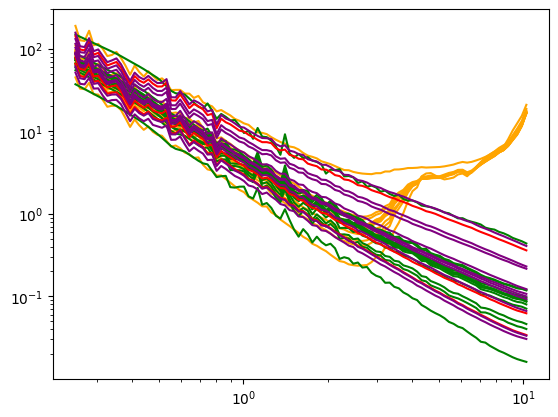

In [9]:
# plotting spectra

# L1
for LF_ind in LF_selected_ind:
    lg_k = data_1.kf
    lg_P = data_1.Y_train[0][LF_ind]
    plt.loglog(10**lg_k, 10**lg_P, color="orange", label="L1: Box100 Part75")

# L2
for LF_ind in LF_selected_ind:
    lg_k = data_2.kf
    lg_P = data_2.Y_train[0][LF_ind]
    plt.loglog(10**lg_k, 10**lg_P, color="green", label="L2: Box25 Part75")

# HF
for HF_ind in HF_selected_ind:
    lg_k = data_2.kf
    lg_P = data_2.Y_train[1][HF_ind]
    plt.loglog(10**lg_k, 10**lg_P, color="red", label="HF: Box100 Part300")

# test
for test_ind in range(len(data_1.X_test[0])):
    lg_k = data_1.kf
    lg_P = data_1.Y_test[0][test_ind]
    plt.loglog(10**lg_k, 10**lg_P, color="purple", label="test: Box100 Part300")

plt.legend()

plt.show()

In [10]:
2*np.pi / 1.33

4.724199479082396

In [ ]:
%%caption
dgmgp = SingleBindGMGP(
                X_train=[data_1.X_train_norm[0][LF_selected_ind], data_2.X_train_norm[0][LF_selected_ind], data_1.X_train_norm[1][HF_selected_ind]],
                Y_train=[data_1.Y_train_norm[0][LF_selected_ind], data_2.Y_train_norm[0][LF_selected_ind], data_1.Y_train_norm[1][HF_selected_ind]],
                n_fidelities=2,
                n_samples=400,
                optimization_restarts=n_optimization_restarts,
                ARD_last_fidelity=False,
                parallel=True,
                )

mode_P_pred, var_P_pred, pred_exacts_dgmgp = validate_dgmgp(data_1, model=dgmgp)

In [16]:
mode_P_pred.shape

(10, 100)

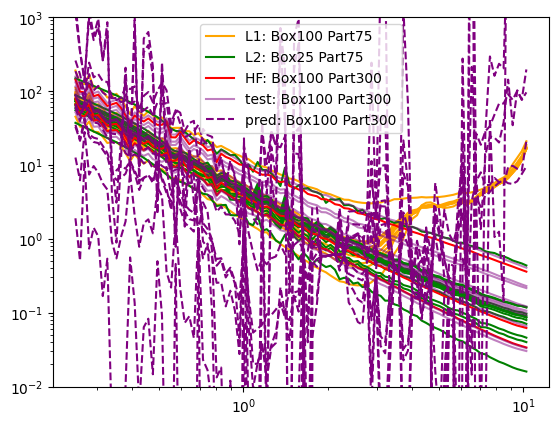

In [26]:
# plotting spectra

# L1
for LF_ind in LF_selected_ind:
    lg_k = data_1.kf
    lg_P = data_1.Y_train[0][LF_ind]
    if LF_ind == LF_selected_ind[0]:
        plt.loglog(10**lg_k, 10**lg_P, color="orange", label="L1: Box100 Part75")
        continue
    plt.loglog(10**lg_k, 10**lg_P, color="orange")

# L2
for LF_ind in LF_selected_ind:
    lg_k = data_2.kf
    lg_P = data_2.Y_train[0][LF_ind]
    if LF_ind == LF_selected_ind[0]:
        plt.loglog(10**lg_k, 10**lg_P, color="green", label="L2: Box25 Part75")
        continue
    plt.loglog(10**lg_k, 10**lg_P, color="green")

# HF
for HF_ind in HF_selected_ind:
    lg_k = data_2.kf
    lg_P = data_2.Y_train[1][HF_ind]
    if HF_ind == HF_selected_ind[0]:
        plt.loglog(10**lg_k, 10**lg_P, color="red", label="HF: Box100 Part300")
        continue
    plt.loglog(10**lg_k, 10**lg_P, color="red")

# test
for test_ind in range(len(data_1.X_test[0])):
    lg_k = data_1.kf
    lg_P = data_1.Y_test[0][test_ind]
    if test_ind == 0:
        plt.loglog(10**lg_k, 10**lg_P, color="purple", label="test: Box100 Part300", alpha=.5)
        continue
    plt.loglog(10**lg_k, 10**lg_P, color="purple", alpha=.5)

for pred_ind in range(len(data_1.X_test[0])):
    lg_k = data_1.kf
    P = mode_P_pred[pred_ind]
    if pred_ind == 0:
        plt.loglog(10**lg_k, P, color="purple", ls='--', label="pred: Box100 Part300")
        continue
    plt.loglog(10**lg_k, P, color="purple", ls='--')

plt.ylim([1e-2, 1e3])
plt.legend()

# plt.show()
plt.savefig("power.pdf")

In [23]:
mode_P_pred

array([[3.27899938e+01, 2.11837781e+01, 3.75470042e+01, 2.41947492e+01,
        2.04176927e+01, 1.97657072e+01, 1.60276965e+01, 1.30157012e+01,
        7.49655442e+00, 6.27195269e+00, 6.68465626e+00, 7.60763138e+00,
        1.12136953e+01, 7.68858887e+00, 4.58610390e+00, 6.66958400e+00,
        7.21673943e+00, 6.21260637e+00, 1.02946111e+01, 6.28730567e+00,
        4.15497579e+00, 3.21109479e+00, 7.03016026e+00, 3.22544992e+00,
        2.36123027e+00, 1.84531944e+00, 1.77096776e+00, 5.72690512e+00,
        1.35824744e+00, 1.12141465e+00, 9.18406448e-01, 5.32747158e-01,
        5.47653290e-01, 3.40114959e-01, 4.06875818e-01, 2.70247794e-01,
        1.43411581e-01, 1.06433895e+00, 1.71419319e-01, 5.38937665e-02,
        6.07728989e-02, 6.95190803e-02, 9.57673874e-02, 9.30754320e-02,
        1.10632195e-01, 1.36670512e-01, 1.00463501e-01, 2.06262508e-01,
        1.66980504e-01, 1.03616332e-01, 5.76599474e-01, 2.66907210e-01,
        8.97128450e-01, 9.33286500e-01, 5.83401367e-01, 5.825833